# TTI Explorer

#### `tti_explorer` is a library for simulating infection spread. This library is built to explore the impact of various test-trace-isolate strategies and social distancing measures on the spread of COVID-19 in the UK. 

This notebook is an introduction to the functionality offered by `tti-explorer`. 

In [ ]:
!git clone https://github.com/rs-delve/tti-explorer.git
%cd tti-explorer
%pip install -q .

Cloning into 'tti-explorer'...
remote: Enumerating objects: 554, done.
remote: Counting objects: 100% (554/554), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 2667 (delta 396), reused 405 (delta 277), pack-reused 2113
Receiving objects: 100% (2667/2667), 31.55 MiB | 20.03 MiB/s, done.
Resolving deltas: 100% (1909/1909), done.
/content/tti-explorer


In [ ]:
import os

import numpy as np
import pandas as pd
from tqdm.notebook import trange

from tti_explorer import config, utils
from tti_explorer.case import simulate_case, CaseFactors
from tti_explorer.contacts import EmpiricalContactsSimulator
from tti_explorer.strategies import TTIFlowModel, RETURN_KEYS

In [ ]:
def print_doc(func):
    print(func.__doc__)

#Installations

In [ ]:
%pip install gpy

     |████████████████████████████████| 1.0MB 4.3MB/s 
     |████████████████████████████████| 71kB 5.8MB/s 
  Created wheel for gpy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633877 sha256=b6f0477a124bd7e50b4e63a0f6af720f195d7028d12aae64aa354d6d405e3333
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102552 sha256=7b76bf19b6da476bd029785b2c6f8d8c6899a19ed573a07f7d1a1a5877be07d0
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built gpy paramz


In [ ]:
%pip install pyDOE

  Created wheel for pyDOE: filename=pyDOE-0.3.8-cp36-none-any.whl size=18178 sha256=be4bcc0461369a0ef7b140c9e95dabb8b7cbb1ab29b35d9d0a78c8ef21bafc97
  Stored in directory: /root/.cache/pip/wheels/7c/c8/58/a6493bd415e8ba5735082b5e0c096d7c1f2933077a8ce34544
Successfully built pyDOE


In [ ]:
%pip install emukit

     |████████████████████████████████| 122kB 4.4MB/s 
     |████████████████████████████████| 31.2MB 149kB/s 
  Created wheel for emukit: filename=emukit-0.4.7-cp36-none-any.whl size=188045 sha256=e378a2dff0c2cf0a82b6a70f4847bc3e98835f71798d43e2d187eb8361f555a8
  Stored in directory: /root/.cache/pip/wheels/37/d9/0c/31e157b6c2834699041b1b4cdf76898474c010ac53543d0611
  Created wheel for emcee: filename=emcee-2.2.1-cp36-none-any.whl size=29596 sha256=15683e866e63b2989ee55897a9e6f04a507a11797e64c8472a10b1d8b246441a
  Stored in directory: /root/.cache/pip/wheels/2f/5d/a5/78f84e23329ad7d9b1787c9d24371100cae74cdefe25eba50d
Successfully built emukit emcee
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existin

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

#Run

Before we do anything, let's make a random state

In [ ]:
import numpy as np
import GPy
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.model_wrappers import SimpleGaussianProcessModel
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.core.loop import UserFunctionWrapper
import matplotlib.pyplot as plt

We will first do a short tour of the functionality, then show how this is put together to generate simulation results.

In [ ]:
def load_csv(pth):
    return np.loadtxt(pth, dtype=int, skiprows=1, delimiter=",")

In [ ]:
path_to_bbc_data = os.path.join("data", "bbc-pandemic")

over18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_o18.csv"))
under18 = load_csv(os.path.join(path_to_bbc_data, "contact_distributions_u18.csv"))

In [ ]:
from tti_explorer.strategies import TTIFlowModel
rng = np.random.RandomState(42)
simulate_contacts = EmpiricalContactsSimulator(over18, under18, rng)
tti_model = TTIFlowModel(rng, **strategy_config)

**Case Config**

In [ ]:
p_under18 = 0.21 # @param {type:"number"}
case_config = {
    'p_under18': p_under18, 
    'infection_proportions': {
        'dist': [0.8333333333333334, 0.1, 0.06666666666666667], 
        'nppl': 120
        }, 
    'p_day_noticed_symptoms': [0, 0.25, 0.25, 0.2, 0.1, 0.05, 0.05, 0.05, 0.05, 0.0], 
    'inf_profile': [0.046966101377360424, 0.15602255610429985, 0.19829974712514023, 0.18356485224565827, 0.14541407040442172, 0.10500447388376151, 0.07130993362939089, 0.04635772205156416, 0.029167894888682697, 0.017892648289720214]
    }

**Contact Config**

In [ ]:
home_sar = 0.3 # @param {type:"number"}
work_sar = 0.045 # @param {type:"number"}
other_sar = 0.045 # @param {type:"number"}
period = 10 # @param {type:"number"}
asymp_factor = 0.5 # @param {type:"number"}
contacts_config = {
   'home_sar': home_sar, 
   'work_sar': work_sar, 
   'other_sar': other_sar, 
   'period': period, 
   'asymp_factor': asymp_factor
   }

**Policy Config**

In [ ]:
compliance = 0.8 # @param {type: "slider", min: 0, max: 1, step: 0.1}
strategy_quarantine_length = 14 # @param {type: "number"}
testing_delay = 2 # @param {type: "number"}
app_trace_delay = 0 # @param {type: "number"}
manual_trace_delay = 1 # @param {type: "number"}
app_coverage = 0.35 # @param {type: "number"}
go_to_school_prob = 0.5 # @param {type: "number"}
wfh_prob = 0.45 # @param {type: "number"}
max_contacts = 10 # @param {type: "number"}

In [ ]:
policy_config = {
    'isolate_individual_on_symptoms': True, 
    'isolate_individual_on_positive': True, 
    'isolate_household_on_symptoms': True, 
    'isolate_household_on_positive': True, 
    'isolate_contacts_on_symptoms': False, 
    'isolate_contacts_on_positive': True, 
    'test_contacts_on_positive': False, 
    'do_symptom_testing': True, 
    'do_manual_tracing': True, 
    'do_app_tracing': True, 
    'fractional_infections': True, 
    'testing_delay': testing_delay, 
    'app_trace_delay': app_trace_delay, 
    'manual_trace_delay': manual_trace_delay, 
    'manual_home_trace_prob': 1.0, 
    'manual_work_trace_prob': 1.0, 
    'manual_othr_trace_prob': 1.0, 
    'met_before_w': 0.79, 
    'met_before_s': 0.9, 
    'met_before_o': 0.9, 
    'max_contacts': max_contacts, 
    'quarantine_length': strategy_quarantine_length, 
    'latent_period': 3, 
    'app_cov': app_coverage, 
    'compliance': compliance, 
    'go_to_school_prob': go_to_school_prob, 
    'wfh_prob': wfh_prob
    }

**Factor Config**

In [ ]:
factor_config = {
    'app_cov': app_coverage, 
    'compliance': compliance, 
    'go_to_school_prob': go_to_school_prob, 
    'wfh_prob': wfh_prob
    }

**Strategy Config**

In [ ]:
strategy_config = {
    'isolate_individual_on_symptoms': True, 
    'isolate_individual_on_positive': True, 
    'isolate_household_on_symptoms': True, 
    'isolate_household_on_positive': True, 
    'isolate_contacts_on_symptoms': False, 
    'isolate_contacts_on_positive': True, 
    'test_contacts_on_positive': False, 
    'do_symptom_testing': True, 
    'do_manual_tracing': True, 
    'do_app_tracing': True, 
    'fractional_infections': True, 
    'testing_delay': testing_delay, 
    'app_trace_delay': app_trace_delay, 
    'manual_trace_delay': manual_trace_delay, 
    'manual_home_trace_prob': 1.0, 
    'manual_work_trace_prob': 1.0, 
    'manual_othr_trace_prob': 1.0, 
    'met_before_w': 0.79, 
    'met_before_s': 0.9, 
    'met_before_o': 0.9, 
    'max_contacts': max_contacts, 
    'quarantine_length': strategy_quarantine_length, 
    'latent_period': 3, 
    'app_cov': app_coverage, 
    'compliance': compliance
    }

In [ ]:
n_cases = 10000
outputs = list()

for _ in trange(n_cases):
    case = simulate_case(rng, **case_config)
    contacts = simulate_contacts(case, **contacts_config)
    while contacts.n_daily['work'] < 10: # keep regen popular kids
      case = simulate_case(rng, **case_config)
      contacts = simulate_contacts(case, **contacts_config) 
    case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
    res = tti_model(case, contacts, case_factors)
    outputs.append(res)

In [ ]:
for o in outputs:
  if o['Base R'] is not np.nan:
    print(o)

{'Base R': 4, 'Effective R': 0.046966101377360424, '# Manual Traces': 7, '# App Traces': 0, '# Tests Needed': 1.0, '# PersonDays Quarantined': 98, 'Has Covid': True, 'Is Symptomatic': True, 'Got tested': True, '# Secondary Infections': 4, '# Secondary Infections Prevented by Social Distancing': 3, '# Secondary Infections Prevented by Isolating Cases with Symptoms': 0.0, '# Secondary Infections Prevented by Contact Tracing': 0.9530338986226394, 'Fractional R': 0.046966101377360424}
{'Base R': 9, 'Effective R': 3.0, '# Manual Traces': 0, '# App Traces': 0, '# Tests Needed': 0, '# PersonDays Quarantined': 0, 'Has Covid': True, 'Is Symptomatic': True, 'Got tested': False, '# Secondary Infections': 9, '# Secondary Infections Prevented by Social Distancing': 6, '# Secondary Infections Prevented by Isolating Cases with Symptoms': 0.0, '# Secondary Infections Prevented by Contact Tracing': 0.0, 'Fractional R': 0.0}
{'Base R': 10, 'Effective R': 0.0, '# Manual Traces': 8, '# App Traces': 0, '# 

Collate and average results across the cases simulated:

In [ ]:
# This cell is mosltly just formatting results...
to_show = [
    RETURN_KEYS.base_r,
    RETURN_KEYS.reduced_r,
    RETURN_KEYS.man_trace,
    RETURN_KEYS.app_trace,
    RETURN_KEYS.tests
]

# scale factor to turn simulation numbers into UK population numbers
nppl = case_config['infection_proportions']['nppl']
scales = [1, 1, nppl, nppl, nppl]

results = pd.DataFrame(
    outputs
).mean(
    0
).loc[
    to_show
].mul(
    scales
).to_frame(
    name=f"Simulation results: {name.replace('_', ' ')}"
).rename(
    index=lambda x: x + " (k per day)" if x.startswith("#") else x
)

results.round(1)

,Simulation results: S3 test based TTI
Base R,9.0
Effective R,2.8
# Manual Traces (k per day),321.4
# App Traces (k per day),48.8
# Tests Needed (k per day),89.9


In [ ]:
results = pd.DataFrame(outputs).mean(0)
print(results.loc["Base R"])

9.032085561497325


In [ ]:
# A basic simulation for experimenting for experimenting with surrogate models
def loss_function_all(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    # General Overview
    contacts_config['asymp_factor'] = x[i,0]
    contacts_config['home_sar'] = x[i,1]
    contacts_config['work_sar'] = x[i,2]
    contacts_config['other_sar'] = x[i,3]
    case_config['p_under18'] = x[i,4]

    # Policy Factors
    policy_config['quarantine_length'] = x[i,6]
    strategy_config['quarantine_length'] = x[i,6]

    policy_config['testing_delay'] = x[i,7]
    strategy_config['testing_delay'] = x[i,7]

    policy_config['app_trace_delay'] = x[i,8]
    strategy_config['app_trace_delay'] = x[i,8]

    policy_config['manual_trace_delay'] = x[i,9]
    strategy_config['manual_trace_delay'] = x[i,9]

    policy_config['go_to_school_prob'] = x[i,11]
    factor_config['go_to_school_prob'] = x[i,11]
    strategy_config['go_to_school_prob'] = x[i,11]

    policy_config['wfh_prob'] = x[i,12]
    factor_config['wfh_prob'] = x[i,12]
    strategy_config['wfh_prob'] = x[i,12]

    policy_config['max_contacts'] = x[i,13]
    strategy_config['max_contacts'] = x[i,13]

    # Compliance Factors
    policy_config['compliance'] = x[i,5]
    factor_config['compliance'] = x[i,5]
    strategy_config['compliance'] = x[i,5]

    policy_config['app_cov'] = x[i,10]
    factor_config['app_cov'] = x[i,10]
    strategy_config['app_cov'] = x[i,10]

    n_cases = 10000
    outputs = list()

    for _ in trange(n_cases):
        case = simulate_case(rng, **case_config)
        contacts = simulate_contacts(case, **contacts_config)
        '''
        while case.under18: # gen only working adults
          case = simulate_case(rng, **case_config)
          contacts = simulate_contacts(case, **contacts_config)
        '''
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["Effective R"])
  return y
   
   

In [ ]:
# A basic simulation for experimenting for experimenting with surrogate models
def loss_function_general_overview(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    # General Overview
    contacts_config['asymp_factor'] = x[i,0]
    contacts_config['home_sar'] = x[i,1]
    contacts_config['work_sar'] = x[i,2]
    contacts_config['other_sar'] = x[i,3]
    case_config['p_under18'] = x[i,4]

    n_cases = 10000
    outputs = list()

    for _ in trange(n_cases):
        case = simulate_case(rng, **case_config)
        contacts = simulate_contacts(case, **contacts_config)
        '''
        while case.under18: # gen only working adults
          case = simulate_case(rng, **case_config)
          contacts = simulate_contacts(case, **contacts_config)
        '''
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["Effective R"])
  return y
   
   

In [ ]:
# A basic simulation for experimenting for experimenting with surrogate models
def loss_function_policy(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    # Policy Factors
    #policy_config['quarantine_length'] = x[i,0]
    #strategy_config['quarantine_length'] = x[i,0]

    #policy_config['testing_delay'] = x[i,0]
    #strategy_config['testing_delay'] = x[i,0]

    #policy_config['app_trace_delay'] = x[i,1]
    #strategy_config['app_trace_delay'] = x[i,1]

    #policy_config['manual_trace_delay'] = x[i,2]
    #strategy_config['manual_trace_delay'] = x[i,2]

    policy_config['go_to_school_prob'] = x[i,0]
    factor_config['go_to_school_prob'] = x[i,0]
    strategy_config['go_to_school_prob'] = x[i,0]

    policy_config['wfh_prob'] = x[i,1]
    factor_config['wfh_prob'] = x[i,1]
    strategy_config['wfh_prob'] = x[i,1]

    #policy_config['max_contacts'] = x[i,3]
    #strategy_config['max_contacts'] = x[i,3]

    n_cases = 10000
    outputs = list()

    for _ in trange(n_cases):
        case = simulate_case(rng, **case_config)
        contacts = simulate_contacts(case, **contacts_config)
        '''
        while not case.under18: # gen only working adults
          case = simulate_case(rng, **case_config)
          contacts = simulate_contacts(case, **contacts_config)
        '''
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["Effective R"])
  return y
   
   

In [ ]:
# A basic simulation for experimenting for experimenting with surrogate models
def loss_function_compliance(x):
  y = np.zeros((x.shape[0],1))
  for i in range(x.shape[0]):
    # Compliance Factors
    policy_config['compliance'] = x[i,0]
    factor_config['compliance'] = x[i,0]
    strategy_config['compliance'] = x[i,0]

    policy_config['app_cov'] = x[i,1]
    factor_config['app_cov'] = x[i,1]
    strategy_config['app_cov'] = x[i,1]

    n_cases = 10000
    outputs = list()

    for _ in trange(n_cases):
        case = simulate_case(rng, **case_config)
        contacts = simulate_contacts(case, **contacts_config)
        
        while case.under18: # gen only working adults
          case = simulate_case(rng, **case_config)
          contacts = simulate_contacts(case, **contacts_config)
        
        case_factors = CaseFactors.simulate_from(rng, case, **factor_config)
        res = tti_model(case, contacts, case_factors)
        outputs.append(res)
    results = pd.DataFrame(outputs).mean(0)
    y[i,0] = float(results.loc["Effective R"])
  return y
   
   

In [ ]:
from emukit.core import ContinuousParameter, DiscreteParameter, ParameterSpace
from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance

variable_domain = [0,1]
reduced_variable_domain = [0, 0.5]
strategy_quarantine_length_domain = [i for i in range(15)]
delay_domain = [i for i in range(8)]
max_contacts_domain = [i for i in range(21)]
           
space = ParameterSpace(
          [
           #ContinuousParameter('asymp_factor', *reduced_variable_domain), 
           #ContinuousParameter('home_sar', *reduced_variable_domain),
           #ContinuousParameter('work_sar', *reduced_variable_domain),
           #ContinuousParameter('other_sar', *reduced_variable_domain),
           #ContinuousParameter('p_under18', *variable_domain),
           #ContinuousParameter('compliance', *variable_domain), 
           #DiscreteParameter('quarantine_length', strategy_quarantine_length_domain), 
           #DiscreteParameter('testing_delay', delay_domain), 
           #DiscreteParameter('app_trace_delay', delay_domain), 
           #DiscreteParameter('manual_trace_delay', delay_domain), 
           #ContinuousParameter('app_coverage', *variable_domain), 
           ContinuousParameter('go_to_school_prob', *variable_domain), 
           ContinuousParameter('wfh_prob', *variable_domain), 
           #DiscreteParameter('max_contacts', max_contacts_domain), 
           ])

design = RandomDesign(space)
x = design.get_samples(5)
y = loss_function_policy(x)

model_gpy = GPRegression(x,y)
model_gpy.kern.variance = 150**2
model_gpy.likelihood.variance.fix(1e-5)
display(model_gpy)

GP_regression.,value,constraints,priors
rbf.variance,22500.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [ ]:
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

Optimization restart 1/1, f = 2.0903264162118598


 /usr/local/lib/python3.6/dist-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


In [ ]:
display(model_gpy)

GP_regression.,value,constraints,priors
rbf.variance,3.4511836832380633,+ve,
rbf.lengthscale,1.5939089866269012,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [ ]:
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition = integrated_variance)
ed.run_loop(loss_function_policy, 10)

Optimization restart 1/1, f = 2.0903264162118598



Optimization restart 1/1, f = 1.3317396633333916



Optimization restart 1/1, f = 1.31703459088925



Optimization restart 1/1, f = -0.00289099960002126



Optimization restart 1/1, f = -2.143193493881789



Optimization restart 1/1, f = -3.9078520749362564



Optimization restart 1/1, f = -4.679457667771761



Optimization restart 1/1, f = 0.514439216170361



Optimization restart 1/1, f = -0.8403339337036186



Optimization restart 1/1, f = -2.3972500822085454



Optimization restart 1/1, f = 2.6884913571137847


Sensitivty Analysis of Pandemic Simulation

In [ ]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [ ]:
main_effects_gp

{'go_to_school_prob': array([0.04816963]), 'wfh_prob': array([0.89234135])}

Text(0, 0.5, '% of explained output variance')

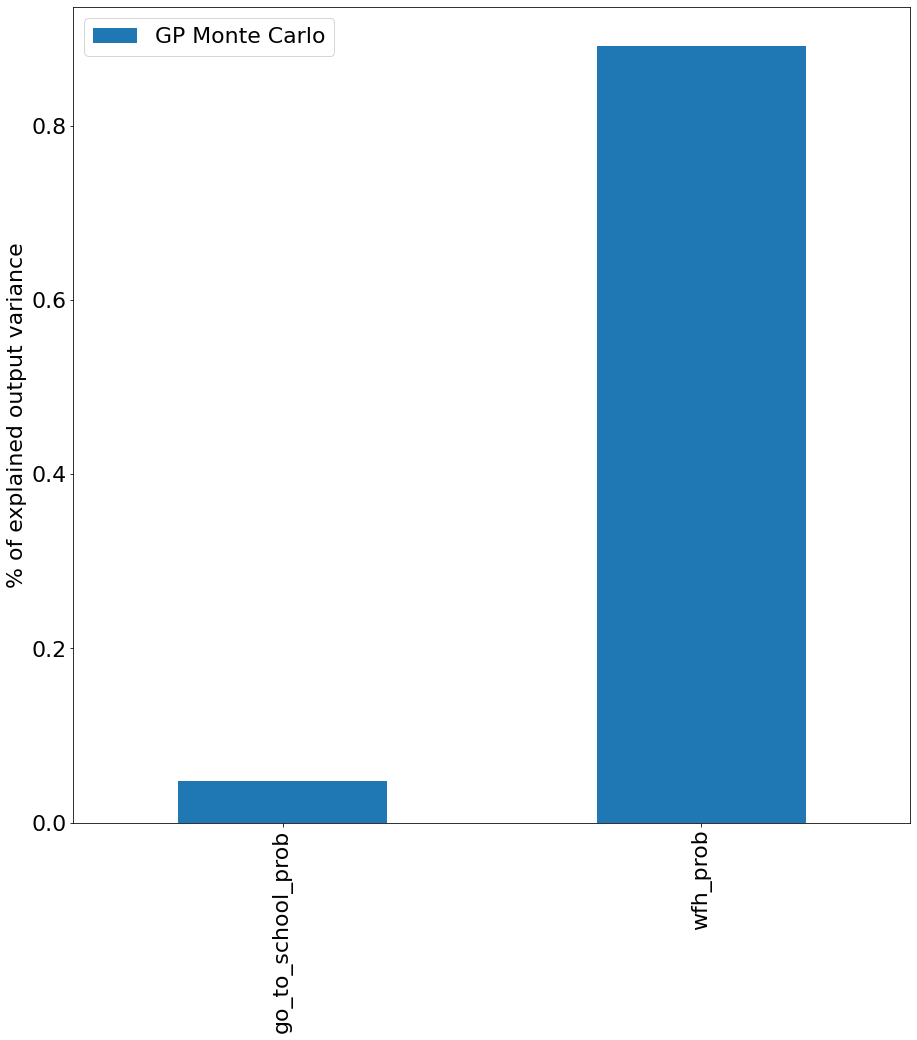

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')